# A Convolutional Neural Network for Unbiased Feature Detection for Neuronal Calcium Imaging Data

Ca++ imaging is a technique in neuroscience that allows optical monitoring of changes in the electrical potential of neurons.  In order to do this, a fluorescent probe sensitive to changes in intracellular calcium (usually genetically encoded) is expressed within neurons. Changes in the intensity of this probe directly reflect the electrical potential of the imaged neuron. 

This type of imaging allows the simultaneous monitoring of many neurons. For example, the light sheet microscope in the Fetcho lab can image up to 170,000 neurons at a rate of 1.4 Hz. To begin to make sense of this data, I am desigining a convolutional neural network to learn features associated with specific types of neurons in an unbiased way. 

As a proof of principle, this notebook will demonstrate a CNN learning filters associated with ca++ transients in active neurons vs the noisy traces of neurons that did not show any changes in membrane potential over a recorded experiment. 

In [1]:
import pickle as p
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data

Data are the image intensity of neuron expressing a calcium indicator over time, acquired at 4.25 Hz per frame. I manually encoded whether or not the trace includes valid calcium transients. Although learning to differentiate between an actively firing neuron and noise seems trivial, I would like to extend the approach in the future using this pre-trained network (transfer learning) to detect subtle differences between different types of neurons in the brain. 

In [2]:
ca_data_array = np.zeros(shape = (0, 1500), dtype = float)
data_label_array = np.zeros(shape=(0,1))

for file in [x for x in os.listdir("data_3P") if x.endswith("pkl")] :
    with open("data_3P/"+file, 'rb') as f:
        ca_data = p.load(f)
    with open("data_3P/labels/"+file[:-4]+"_Label.pkl", 'rb') as g:
        labels = p.load(g)
    
    try:
        ca_data_array = np.append(ca_data_array, ca_data, axis=0)
        data_label_array = np.append(data_label_array, labels.astype('bool').ravel()[:,None], axis=0)
    except:
        pass

print(ca_data_array.shape)
print(data_label_array.shape)

(2472, 1500)
(2472, 1)


In [3]:
fraction_true = np.sum(data_label_array)/data_label_array.shape[0]
print ("%2.2f percent of the data is labeled as good calcium signals" % (fraction_true * 100 ))

33.05 percent of the data is labeled as good calcium signals


We want 50% of the data to be negative and 50% to be positive. To do this I will randomly select the an equal number of negative data. 

In [4]:
n_to_select = np.sum(data_label_array).astype(int)
selection_array = np.random.permutation(data_label_array.shape[0] - n_to_select)
negative_data = np.where(data_label_array==0)
positive_data_selection = np.where(data_label_array==1)[0]

negative_data_selection = negative_data[0][selection_array[:n_to_select]]

## Pre-processing of Data

I don't want the algorithm to pick up on differences in raw intensity values so i will subtract by the mean of each signal beforehand. I will also divide divide by the standard deviation of each signal. Although this will stretch out noisy traces, i want the neural network to learn about transient shapes rather than amplitudes. These assumptions may be re-visited in the future

In [5]:
ca_data_half = ca_data_array[:,::2] + ca_data_array[:,1::2]
ca_data_half /= 2
ca_data_half.shape

(2472, 750)

In [6]:
ca_data_proc = ca_data_half - np.mean(ca_data_half, axis=1)[:,None]
ca_data_proc /= np.std(ca_data_half, axis=1)[:,None]

#smoothed version for plotting
window_size = 5
smoothing_kernel = np.ones(window_size)*window_size**-1
ca_data_smooth = np.zeros_like(ca_data_proc)

for k in range(ca_data_proc.shape[0]):
    ca_data_smooth[k,:] = np.convolve(smoothing_kernel, ca_data_proc[k,:], mode='same')

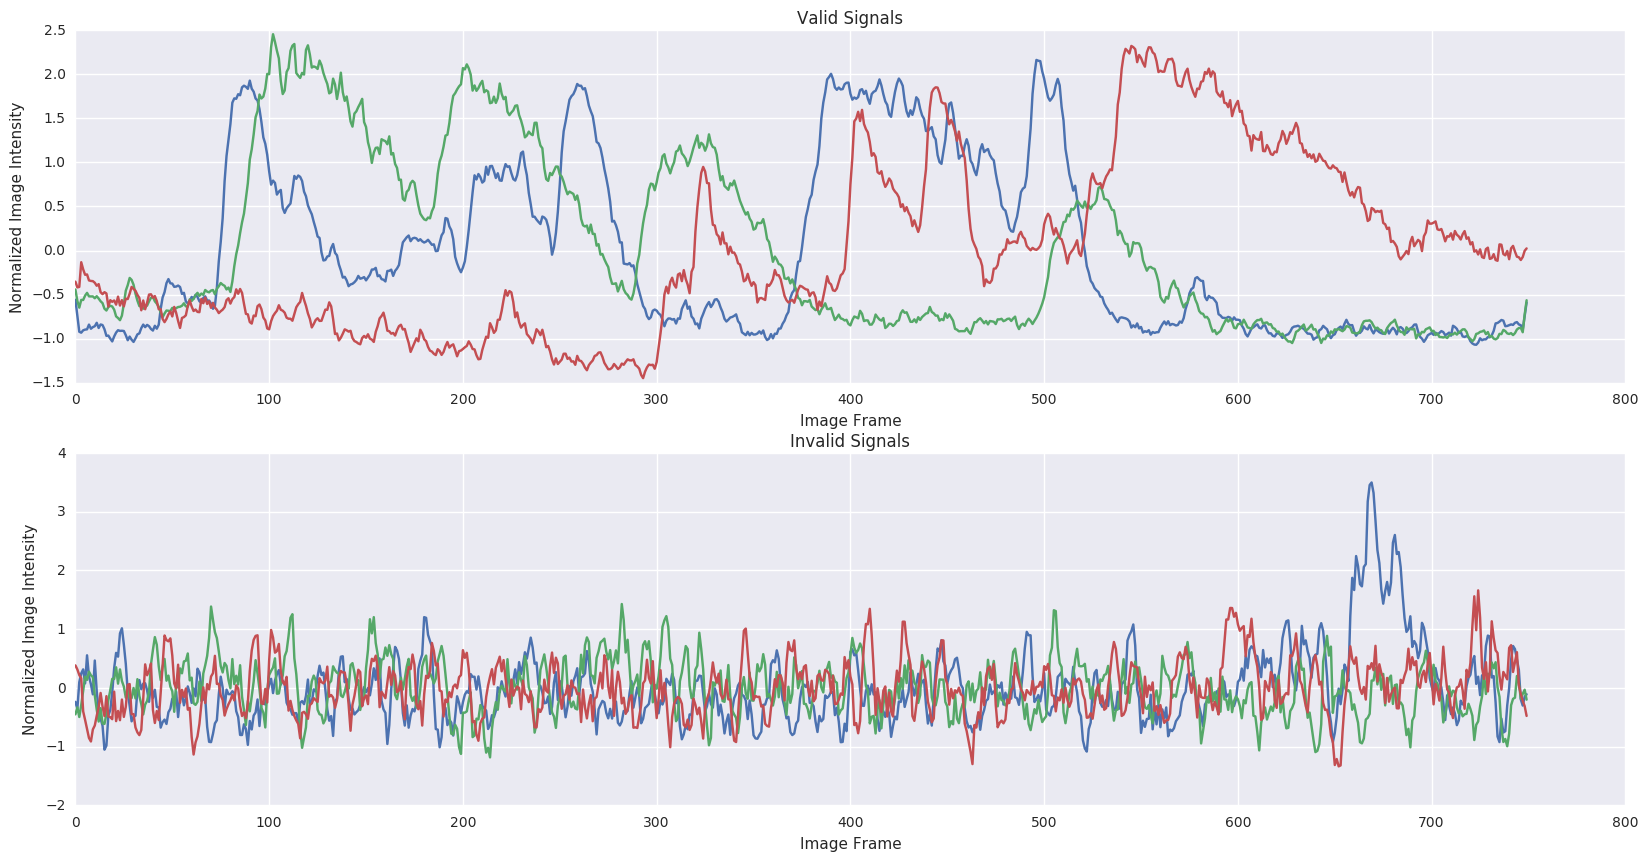

In [7]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(20)

num2plot = 3

good_sig = np.where(data_label_array == True)
bad_sig = np.where(data_label_array == False)

g_ca_plot = ca_data_smooth[good_sig[0],:]
b_ca_plot = ca_data_smooth[bad_sig[0],:]

#max_sig_g = list( reversed( np.argsort( np.sum( g_ca_plot, axis=1))) )
#max_sig_b = list( reversed( np.argsort( np.sum( b_ca_plot, axis=1))) )

#signal_idx = [2,5,6]
#signal_idx2 = [100,101,102]
#gs = [max_sig_g[i] for i in signal_idx]
#bs = [max_sig_b[i] for i in signal_idx2]

gs = np.array([99,714,478])
bs = np.array([871,697,922])
ax[0].plot(g_ca_plot[gs,:].T)
ax[0].set_xlabel("Image Frame")
ax[0].set_ylabel("Normalized Image Intensity")
ax[0].set_title("Valid Signals")

ax[1].plot(b_ca_plot[bs,:].T)
ax[1].set_xlabel("Image Frame")
ax[1].set_ylabel("Normalized Image Intensity")
ax[1].set_title("Invalid Signals")

vis_good = g_ca_plot[gs[0],:]
vis_bad = b_ca_plot[bs[1], :]

# CNN 

The idea will be to develop a convolutional neural network to regress signals to learn signal features. I'm most familiar with scikit-learn and tensorflow at this point, so will use tensorflow. 

In [8]:
import tensorflow as tf

In [9]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

# Network Architecture

To start, I've decided to use one convolutional layer followed by a number of hidden layers. The cell below allows easy tuning of the hyperparameters, including number of layers and number of convolutional filters to train. For now, loss is simply defined as the squared difference between labels and predicted values. 

In [10]:
#some experimenting to get the dimensions of the model right. 
reset_tf()
x2 = tf.placeholder(tf.float32, shape=[None,ca_data_smooth.shape[1],1])
x3 = tf.layers.conv1d(x2, filters = 5, kernel_size = 43, strides = 1, name="Features")
x4 = tf.reduce_max(x3, axis=1)
x5 = tf.reduce_mean(x3, axis=1)
x6 = tf.concat([x4,x5], axis=1)

In [11]:
x6.shape #here we collapse each convolution to its max across the entire time series!!

TensorShape([Dimension(None), Dimension(10)])

In [12]:
reset_tf()

x = tf.placeholder(tf.float32, shape=[None,ca_data_smooth.shape[1],1])
y_true = tf.placeholder(tf.float32, shape=[None,1])

#num_filters = 8
#hidden_layers = [16, 8, 4]

#hidden_layers = [2,2] got 75% sensitivity, with filters=2, kernel_size =87, strides =20
num_filters = 2
hidden_layers = [4]

Uo = hidden_layers[-1]

#f1 = tf.Variable(tf.random_normal(shape=[1500, features]))
W = tf.Variable(tf.random_normal(shape=[Uo,1]))

#W = tf.Variable(tf.random_normal(shape=[8,1]))
tf.summary.histogram("Weights", W)

def nnetwork(x, num_features, W, hidden_layers):
    
    x = tf.layers.conv1d(x, filters = num_features, kernel_size = 45, strides = 1, 
                         kernel_initializer = tf.initializers.random_normal(mean=1, stddev=0.1), name="Features")
    tf.summary.histogram("Kernels", x)
    #x = tf.layers.max_pooling1d(x, pool_size = 2, strides = 1)
    
    #x = tf.reshape(x, [-1, x.shape[1:].num_elements()])
    x = tf.abs(x) #improved things a lot!! with kernel=43, 80% accuracy.
    x1 = tf.reduce_max(x, axis=1)
    x1 = tf.layers.batch_normalization(x1)
    x2 = tf.reduce_mean(x, axis=1)
    x2 = tf.layers.batch_normalization(x2)
    
    x = tf.concat([x1,x2], axis=1)
    
    layerCount = 0
    for layer in hidden_layers:
        #x = tf.nn.dropout(x, keep_prob=0.7)
        layer_name = "hidden"+str(layerCount)
        layerCount+=1
        x = tf.layers.dense(x, layer, activation=tf.nn.relu, use_bias=True, name=layer_name)
        x = tf.layers.batch_normalization(x)
    
    b = tf.Variable(tf.random_normal(shape=[1,1]))

    y = tf.matmul(x,W) + b
    
    return y

y = nnetwork(x, num_filters, W, hidden_layers)

#ys = tf.nn.sigmoid(y)
loss_per_sample = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y)
loss = tf.reduce_sum(loss_per_sample)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [13]:
ys = tf.nn.sigmoid(y)
y_pred = tf.round(ys)
correct_prediction = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

The cell below trains the network, allowing adjustment of number of iterations and batch size. 

In [14]:
reset_vars()


iter_num = 1200
batch_size = 50

reset_vars()
loss_record = []
train_acc = []
test_acc = []

data = np.concatenate( (ca_data_smooth[positive_data_selection,:], ca_data_smooth[negative_data_selection,:]), axis=0)
Y = np.concatenate( (data_label_array[positive_data_selection], data_label_array[negative_data_selection]), axis=0)
datascramble = np.random.permutation(range(data.shape[0]))

XTrain = data[datascramble[:1300],:]
YTrain = Y[datascramble[:1300]]

XTest =  data[datascramble[1300:1450],:]
YTest = Y[datascramble[1300:1450]]

XVal = data[datascramble[1450:],:]
YVal  = Y[datascramble[1450:]]

#tensor board stuff
logfiledir = "/home/ubuntu/ebs0/CaTransientProject/tensorboard/"
writer1 = tf.summary.FileWriter(logfiledir+"1")
merged_summary = tf.summary.merge_all()
writer2 = tf.summary.FileWriter(logfiledir+"2")

writer1.add_graph(sess.graph)
writer2.add_graph(sess.graph)

for epoch in range(iter_num):
    batch_indices = np.random.choice(XTrain.shape[0], size=batch_size, replace=False)
    batch_train_x = XTrain[batch_indices,:]
    batch_train_y = YTrain[batch_indices]
    
    sess.run(optimizer, feed_dict = {x: batch_train_x[:,:,None], y_true: batch_train_y})
    epoch_loss = sess.run(loss, feed_dict={x: batch_train_x[:,:,None], y_true: batch_train_y})
    epoch_train_accuracy = sess.run(accuracy, feed_dict={x: XTrain[:,:,None], y_true: YTrain})
    epoch_test_accuracy = sess.run(accuracy, feed_dict={x: XTest[:,:,None], y_true: YTest})
    
    loss_record.append(epoch_loss)
    train_acc.append(epoch_train_accuracy)
    test_acc.append(epoch_test_accuracy)
    
    if np.mod(epoch,5) == 0:
        s = sess.run(merged_summary, feed_dict = {x: batch_train_x[:,:,None], y_true: batch_train_y})
        writer2.add_summary(s, epoch)
        
    if np.mod(epoch,500) == 0:
        #print(epoch_loss)
        print("epoch %3.0f loss: %4.4f, train_acc: %2.4f, test_acc: %2.4f" % (epoch, epoch_loss, epoch_train_accuracy, epoch_test_accuracy))
        
    

epoch   0 loss: 639.0622, train_acc: 0.4954, test_acc: 0.5200
epoch 500 loss: 33.4160, train_acc: 0.6754, test_acc: 0.6800
epoch 1000 loss: 32.7813, train_acc: 0.6592, test_acc: 0.6267


# Training Results

We can see below that the model overfits quickly, achieving 96% accuracy on the training data but increasing only slightly above chance (to about 60% accuracy) on the cross-validation data. Loss on the training data declines steadily over training. 

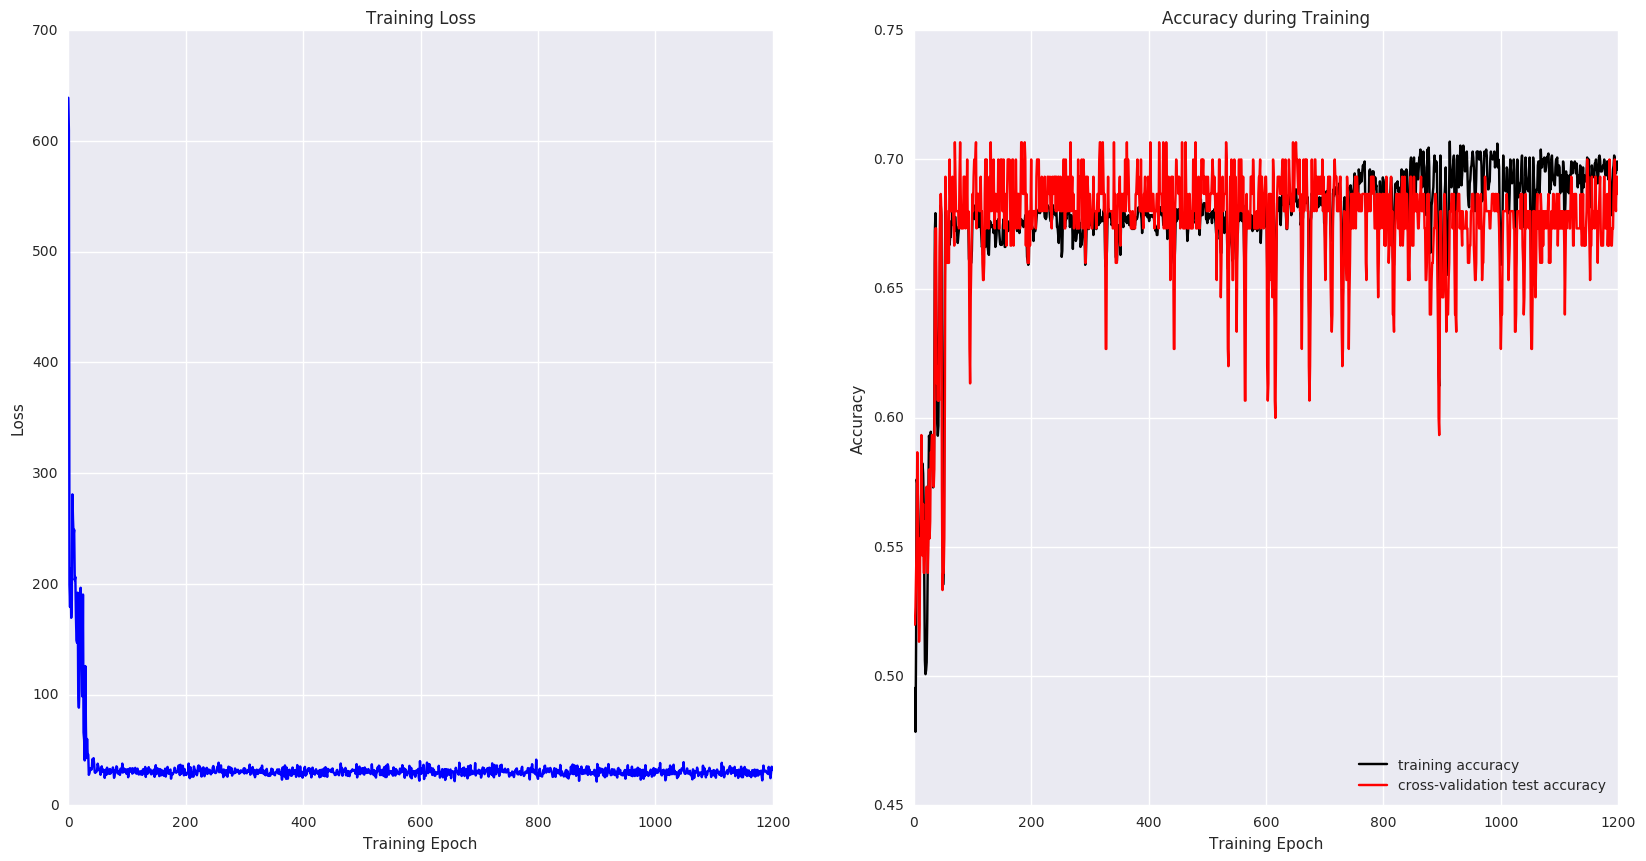

In [15]:
f, ax = plt.subplots(1,2)
f.set_figwidth(20)
f.set_figheight(10)

ax[0].plot(loss_record,'b')
ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Loss")

trnh, = ax[1].plot(train_acc, 'k')
tsth, = ax[1].plot(test_acc,'r')
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy during Training")
plt.legend([trnh,tsth],["training accuracy","cross-validation test accuracy"], loc="lower right")

In [16]:
#Validation Accuracy

va = sess.run(accuracy, feed_dict={x: XVal[:,:,None], y_true: YVal})
print ("Validation accuracy is %2.2f" % va)

Validation accuracy is 0.64


In [17]:
from sklearn.metrics import confusion_matrix
y_predicted = sess.run(y_pred, feed_dict = {x: XVal[:,:,None], y_true: YVal})
tn, fp, fn, tp= confusion_matrix(y_predicted, YVal).ravel()

sensitivity = tp/(tp+fn)
specificity = tn/(tn + fp)

print ("Sensitivity is %2.2f and specificity is %2.2f" % (sensitivity, specificity))

Sensitivity is 0.69 and specificity is 0.60


# Model Results

After playing with the parameters rather extensively, I found that in general this architecture does not exceed about 60% accuracy on the test data. Thus, it is convincingly performing above chance levels but isn't great!

# Results Records
70% test accuracy with network [16, 8, 4] with 8 filters, filter length=43, 50% dropout.  4000 training epochs

Altering filter size to 21, reduced metrics to 67% accuracy. 

Altering filter size to 8 resulted in 64% accuracy, interestingly had higher sensitivity (around 70% in the past sensitivity and specificity were even). 

Increasing filter size to 87 caused sensitivity to increase to 77%. However, overall accuracy is still just 60%.

CHANGING LOSS:
perhaps, should change loss to only reflect sensitivity!

# Visualization of Hidden Layers

In [18]:
# Visualize conv1 kernels

#tf.global_variables() #<--displays all variables

with tf.variable_scope('Features') as scope:
    tf.get_variable_scope().reuse_variables()
    kernel = tf.get_variable('kernel')

features = sess.run(kernel)
features = features.reshape(features.shape[0],np.prod(features.shape[1:]))

In [19]:
hidden_k = []

for layer in range( len(hidden_layers)):
    layerName = "hidden"+str(layer)
    
    with tf.variable_scope(layerName) as scope:
        tf.get_variable_scope().reuse_variables()
        layerd = tf.get_variable('kernel') 
        layerWt = sess.run(layerd)
    hidden_k.append(sess.run(layerd) )

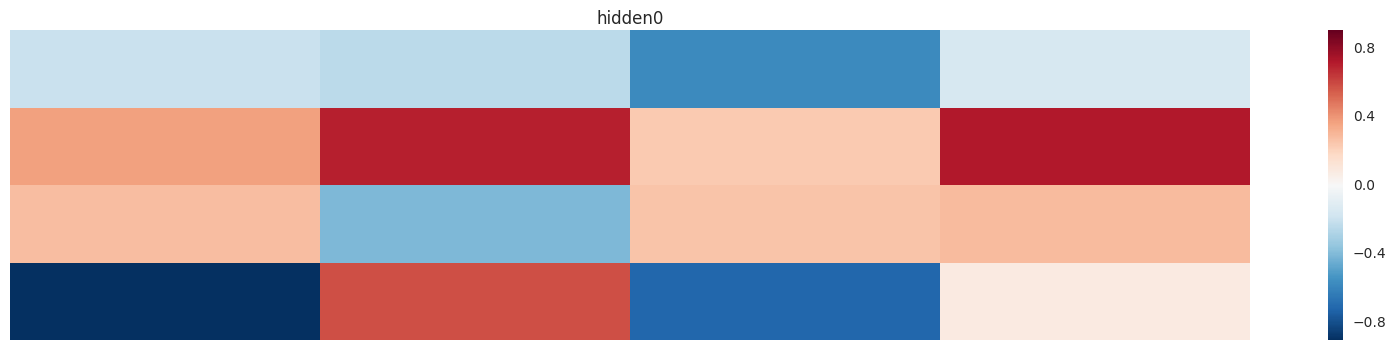

In [20]:
fig, ax = plt.subplots(1, len(hidden_layers))
fig.set_figwidth(20)
   
for layer in range( len(hidden_layers)):
    layerName = "hidden"+str(layer)
   
    if len(hidden_layers) == 1:
        sns.heatmap( hidden_k[layer], ax=ax, xticklabels=[], yticklabels=[])
        ax.set_title(layerName)
    else:
        sns.heatmap( hidden_k[layer], ax=ax[layer], xticklabels=[], yticklabels=[])
        ax[layer].set_title(layerName)

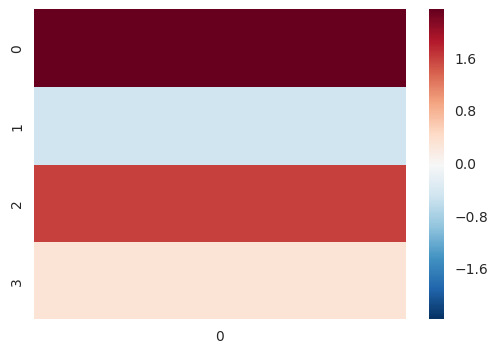

In [21]:
Wt = sess.run(W)
sns.heatmap(Wt)

# Visualization of convolutional filters

'\nfor m in range(len(ax) ):\n    for n in range(2):\n        if pltn < features.shape[1]:\n            ax[m][n].plot(features[:,pltn])\n            ax[m][n].set_title("feature %2.0f" % (pltn+1))\n        pltn+=1\n'

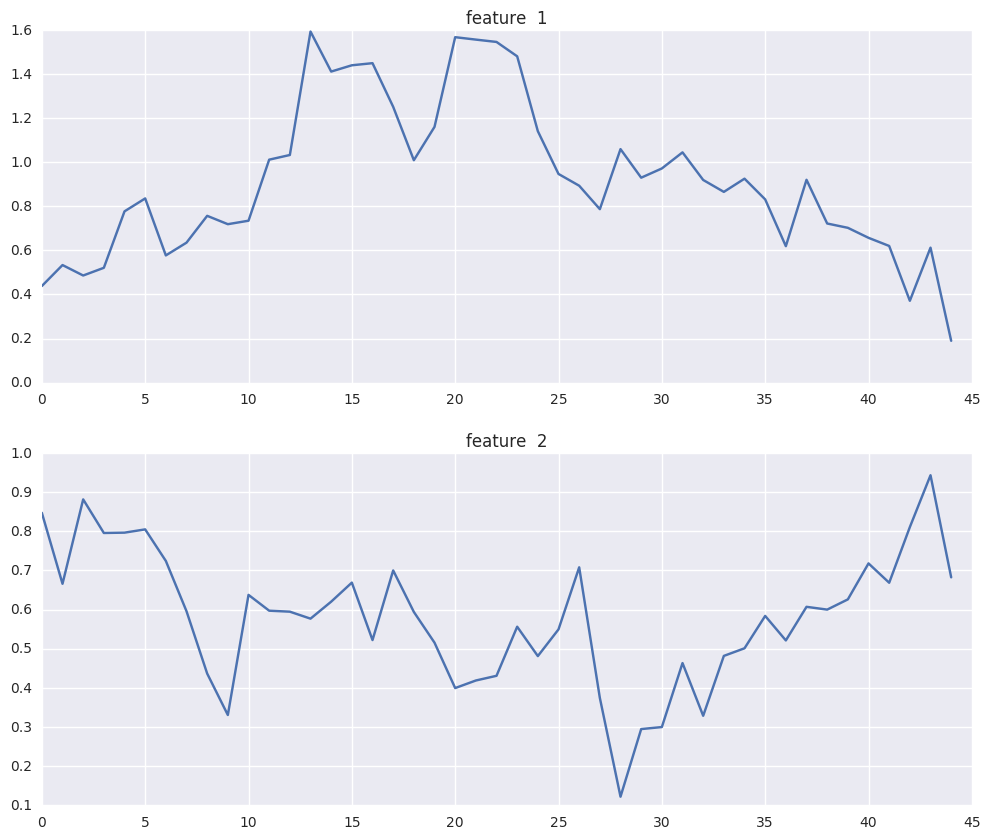

In [22]:
#n_subplot_rows = int( np.ceil(num_filters/2) )
fz, ax = plt.subplots(num_filters,1)

fz.set_figwidth(12)
fz.set_figheight(10)
#pltn = 0

for m in range(num_filters):
    ax[m].plot(features[:,m])
    ax[m].set_title("feature %2.0f" % (m+1))
    
"""
for m in range(len(ax) ):
    for n in range(2):
        if pltn < features.shape[1]:
            ax[m][n].plot(features[:,pltn])
            ax[m][n].set_title("feature %2.0f" % (pltn+1))
        pltn+=1
"""


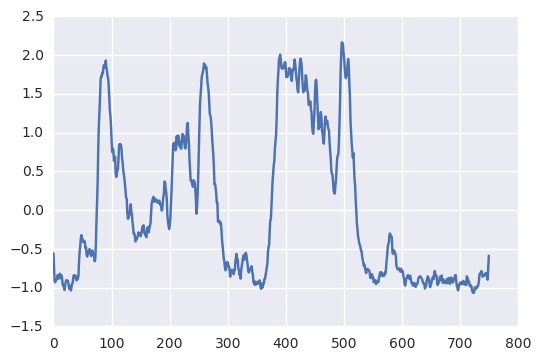

In [23]:
plt.plot(vis_good)

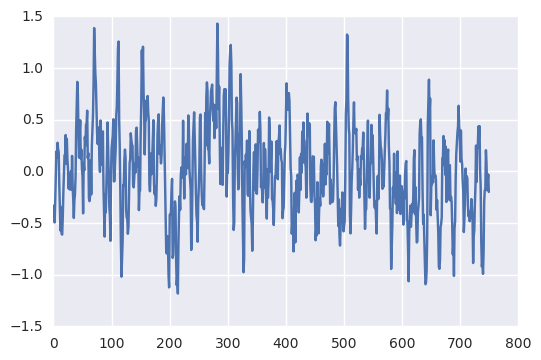

In [24]:
plt.plot(vis_bad)

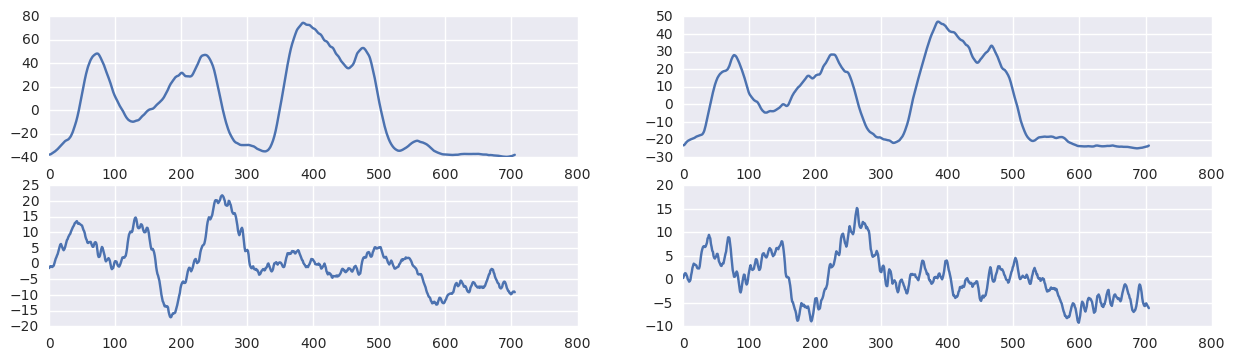

In [25]:
fz, ax = plt.subplots(2, 2)
fz.set_figwidth(15)

a = np.convolve(features[:,0],vis_good,mode='valid')
ax[0][0].plot(a)

b = np.convolve(features[:,1],vis_good,mode='valid')
ax[0][1].plot(b)

gFeatures = [np.mean(a), np.mean(b), np.max(a), np.max(b)]
a = np.convolve(features[:,0],vis_bad,mode='valid')
ax[1][0].plot(a)

b = np.convolve(features[:,1],vis_bad,mode='valid')
ax[1][1].plot(b)

bFeatures = [np.mean(a), np.mean(b), np.max(a), np.max(b)]

In [26]:
print(gFeatures)
print(bFeatures)

[2.3306819594648225, 1.4815265198916407, 74.411593920999167, 46.941521338324762]
[0.50349456945671545, 0.31244793249912611, 21.829703234818943, 15.182366152105105]


# Future Directions

The architecture has some fundamental limitations for learning the types of features I envisioned. However, the model is able to train. It may be possible that adding more convolutional layers or increasing the amount of max pooling to cover the entire time series (so that each filter is represented by its maximum activation) may help alleviate the issue. 